<a href="https://colab.research.google.com/github/HackerJacky/Econometrics_project/blob/main/%E8%A8%88%E9%87%8F%E7%B6%93%E6%BF%9F%E5%AD%B8%E9%9D%9E%E8%BE%B2%E5%B0%B1%E6%A5%AD%E6%A8%A1%E5%9E%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install fredapi


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import yfinance as yf
import datetime as dt
import pandas_datareader.data as web
from fredapi import Fred
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen
from google.colab import drive
from IPython.display import display
from scipy.stats import ttest_rel


In [5]:
# 設定 FRED API 金鑰
fred = Fred(api_key='cb616b95642d785dc1427e4e2f53e61e')
drive.mount('/content/drive')
# 設定時間區間
start = '2015-01-01'
end = '2025-03-01'
SP500=yf.download('^GSPC',start=start,end=end)
SP500_data=SP500['Close']
SP500_data.columns=['Close']

#CPI
cpi = fred.get_series('CPIAUCSL', observation_start=start, observation_end=end).diff().dropna()
#聯邦利率
rate = fred.get_series('FEDFUNDS', observation_start=start, observation_end=end).diff().dropna()
#VIX 指數（恐慌指數）
vix=yf.download('^VIX',start=start,end=end)
vix_data=vix['Close']
vix_data.columns=['Close']
#非農就業人數
nfp = pd.read_excel('/content/drive/MyDrive/計量經濟學報告參考文獻/NFP_data.xlsx')
#M1貨幣流通量
m1 = fred.get_series('M1SL',observation_start=start, observation_end=end).dropna()
m1_yoy = m1.pct_change(12) * 100

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


###非農就業和S&P500的回歸

In [6]:
# 先確保公告日是 datetime 格式
nfp['公布日期'] = pd.to_datetime(nfp['公布日期'])

# 將收盤價轉換為 DataFrame 並建立日期欄
df_price = SP500_data.reset_index()[['Date', 'Close']]
df_price = df_price.sort_values('Date')

# 儲存結果
results = []

for date in nfp['公布日期']:
    try:
        price_prev = df_price[df_price['Date'] < date].iloc[-1]['Close']
        price_today = df_price[df_price['Date'] == date].iloc[0]['Close']
        price_next = df_price[df_price['Date'] > date].iloc[0]['Close']

        results.append({
            '公布日期': date,
            '前一天收盤價': price_prev,
            '當天收盤價': price_today,
            '隔天收盤價': price_next
        })
    except:
        continue  # 若日期缺資料則略過

df_window = pd.DataFrame(results)

# 計算報酬率（以百分比表示）
df_window['前一天報酬率'] = (df_window['當天收盤價'] - df_window['前一天收盤價']) / df_window['前一天收盤價']
df_window['隔天報酬率'] = (df_window['隔天收盤價'] - df_window['當天收盤價']) / df_window['當天收盤價']

print(df_window)

         公布日期       前一天收盤價        當天收盤價        隔天收盤價    前一天報酬率     隔天報酬率
0  2025-02-07  6083.569824  6025.990234  6066.439941 -0.009465  0.006713
1  2025-01-10  5918.250000  5827.040039  5836.220215 -0.015412  0.001575
2  2024-12-06  6075.109863  6090.270020  6052.850098  0.002495 -0.006144
3  2024-11-01  5705.450195  5728.799805  5712.689941  0.004093 -0.002812
4  2024-10-04  5699.939941  5751.069824  5695.939941  0.008970 -0.009586
..        ...          ...          ...          ...       ...       ...
67 2019-05-03  2917.520020  2945.639893  2932.469971  0.009638 -0.004471
68 2019-04-05  2879.389893  2892.739990  2895.770020  0.004636  0.001047
69 2019-03-08  2748.929932  2743.070068  2783.300049 -0.002132  0.014666
70 2019-02-01  2704.100098  2706.530029  2724.870117  0.000899  0.006776
71 2019-01-04  2447.889893  2531.939941  2549.689941  0.034336  0.007010

[72 rows x 6 columns]


In [7]:
# 重新處理 NFP 數據
def parse_k(value):
    if isinstance(value, str):
        value = value.replace(',', '')  # 移除千分位逗號
        if 'K' in value:
            return float(value.replace('K', '')) * 1000
    return pd.to_numeric(value, errors='coerce')

nfp['公布值_num'] = nfp['公布值'].apply(parse_k)
nfp['預測值_num'] = nfp['預測值'].apply(parse_k)
nfp['公布日期'] = pd.to_datetime(nfp['公布日期'])
nfp['surprise'] = (nfp['公布值_num'] - nfp['預測值_num']) / nfp['預測值_num']

# 合併 NFP + 收盤價報酬率資料
df_window['公布日期'] = pd.to_datetime(df_window['公布日期'])
df_final = pd.merge(nfp, df_window, on='公布日期', how='inner')

# 篩選出最終欄位並去除缺漏值
df_final = df_final[[
    '公布日期', '公布值', '預測值', '公布值_num', '預測值_num', 'surprise',
    '前一天收盤價', '當天收盤價', '隔天收盤價',
    '前一天報酬率', '隔天報酬率'
]].dropna()

# 顯示清理後的前幾筆資料
display(name="整理後的非農與報酬資料", dataframe=df_final)
df_final.head()

,公布日期,公布值,預測值,公布值_num,預測值_num,surprise,前一天收盤價,當天收盤價,隔天收盤價,前一天報酬率,隔天報酬率
0,2025-02-07,143K,169K,143000.0,169000.0,-0.153846,6083.569824,6025.990234,6066.439941,-0.009465,0.006713
1,2025-01-10,256K,164K,256000.0,164000.0,0.560976,5918.250000,5827.040039,5836.220215,-0.015412,0.001575
2,2024-12-06,227K,202K,227000.0,202000.0,0.123762,6075.109863,6090.270020,6052.850098,0.002495,-0.006144
3,2024-11-01,12K,106K,12000.0,106000.0,-0.886792,5705.450195,5728.799805,5712.689941,0.004093,-0.002812
4,2024-10-04,254K,147K,254000.0,147000.0,0.727891,5699.939941,5751.069824,5695.939941,0.008970,-0.009586


In [8]:


# 去除缺值
valid = df_window.dropna(subset=['前一天報酬率', '隔天報酬率'])

# t 檢定
t_stat, p_val = ttest_rel(valid['隔天報酬率'], valid['前一天報酬率'])

print(f't = {t_stat:.4f}, p = {p_val:.4f}')


t = -1.1901, p = 0.2380


In [9]:
# # 建立回歸模型：使用 surprise 解釋隔天報酬率
X = df_final[['surprise']]
X = sm.add_constant(X)
y = df_final['隔天報酬率']

model_robust = sm.OLS(y, X, missing='drop').fit(cov_type='HC1')
print(model_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                  隔天報酬率   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     4.429
Date:                Sun, 01 Jun 2025   Prob (F-statistic):             0.0389
Time:                        11:04:26   Log-Likelihood:                 202.48
No. Observations:                  72   AIC:                            -401.0
Df Residuals:                      70   BIC:                            -396.4
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.183      0.8

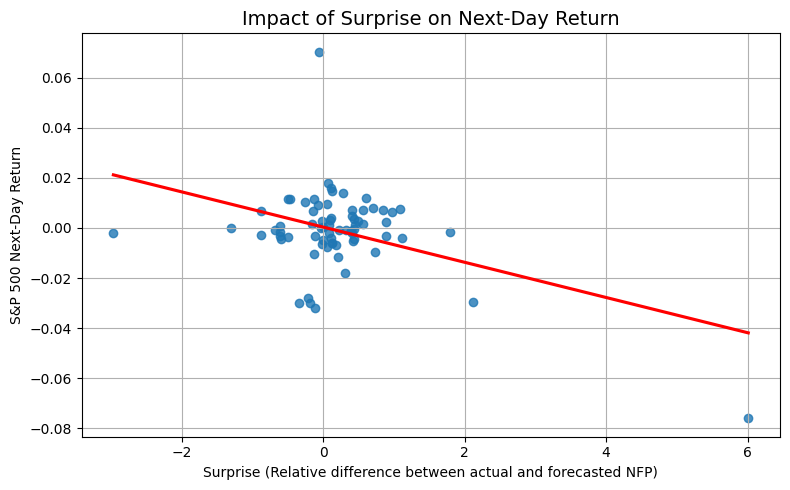

In [15]:
plt.figure(figsize=(8, 5))
sns.regplot(x='surprise', y='隔天報酬率', data=df_final, ci=None, line_kws={"color": "red"})
plt.title('Impact of Surprise on Next-Day Return', fontsize=14)
plt.xlabel('Surprise (Relative difference between actual and forecasted NFP)')
plt.ylabel('S&P 500 Next-Day Return')
plt.grid(True)
plt.tight_layout()
plt.show()


###S&P500和CPI以及M1貨幣供給的關聯性

In [ ]:
#VAR定態需要檢定單根還需要檢定是否為定態
#可以思考利率partial out 其他變數
#

In [ ]:
SP500 = yf.download('^GSPC', start=start, end=end)['Close']
SP500_monthly = SP500.resample('M').last()
SP500_ret = np.log(SP500_monthly).diff().dropna()
SP500_ret.name = 'ret_sp500'

# 資料轉月頻
def to_monthly(series):
    return series.resample('M').last()

cpi = to_monthly(fred.get_series('CPIAUCSL', observation_start=start, observation_end=end).dropna())
rate = to_monthly(fred.get_series('FEDFUNDS', observation_start=start, observation_end=end).dropna())
cci = to_monthly(fred.get_series('UMCSENT', observation_start=start, observation_end=end).dropna())
m1 = to_monthly(fred.get_series('M1SL', observation_start=start, observation_end=end).dropna())
m1_yoy = m1.pct_change(12) * 100

# 整合資料
df = pd.concat([SP500_ret, cpi, rate, cci,m1_yoy], axis=1)
df.columns = ['ret_sp500', 'cpi','rate','cci', 'm1_yoy']
df = df.dropna()

# ADF 單根檢定
def adf_test(series, name):
    result = adfuller(series)
    return pd.Series({
        'Variable': name,
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Is Stationary (5%)': result[1] < 0.05
    })

adf_table = pd.concat([adf_test(df[col], col) for col in df.columns[1:]], axis=1).T
print("\n=== ADF 單根檢定結果 ===")
print(adf_table)

#由此可以看出定態檢定沒過,所以我們不能使用var

[*********************100%***********************]  1 of 1 completed
<ipython-input-9-f7833c0780d5>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  SP500_monthly = SP500.resample('M').last()
<ipython-input-9-f7833c0780d5>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return series.resample('M').last()



=== ADF 單根檢定結果 ===
  Variable ADF Statistic   p-value Is Stationary (5%)
0      cpi     -0.007134  0.957938              False
1   m1_yoy     -1.587477  0.489881              False
